In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random, json
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

""" LSTM Cell """
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        k = 1.0 / math.sqrt(hidden_size)
        self.W = nn.Parameter(torch.empty(input_size, 4 * hidden_size).uniform_(-k, k)) # this matrix is a concatenation of the i, f, g, o weight matrices
        self.U = nn.Parameter(torch.empty(hidden_size, 4 * hidden_size).uniform_(-k, k))
        self.b = nn.Parameter(torch.zeros(4 * hidden_size))

    def forward(self, x, h, c):
        gates = x @ self.W + h @ self.U + self.b
        i, f, g, o = gates.chunk(4, dim=1)
        i, f, o = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


""" Encoder """
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm_cell = LSTMCell(embedding_dim, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, x):  # x: (batch, seq_len)
        batch_size, seq_len = x.size()
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(seq_len):
            emb = self.embedding(x[:, t])  # (batch, emb_dim)
            h, c = self.lstm_cell(emb, h, c)
        return h, c

""" Decoder """
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_dim, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim, padding_idx=pad_idx)
        self.lstm_cell = LSTMCell(embedding_dim, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_h, encoder_c, targets=None, seq_len=50, teacher_forcing_ratio=0.5):
        batch_size = encoder_h.size(0)
        h, c = encoder_h, encoder_c
        outputs = []

        # start token = index 1 (you can change if needed)
        input_t = torch.full((batch_size,), 0, dtype=torch.long, device=encoder_h.device)

        for t in range(seq_len):
            emb = self.embedding(input_t)  # (batch, emb_dim)
            h, c = self.lstm_cell(emb, h, c) # (batch, hidden_size)
            logits = self.out(h) # (batch, output_size)
            outputs.append(logits.unsqueeze(1)) # (batch, 1, output_size)

            # decide if we use teacher forcing
            if targets is not None and random.random() < teacher_forcing_ratio:
                input_t = targets[:, t] # (batch,)
            else:
                input_t = logits.argmax(dim=-1) # (batch,)

        return torch.cat(outputs, dim=1) # (batch, seq_len, output_size)


""" Implementing the encoder-decoder sequence to sequence model """
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_tags, emb_dim=128, pad_idx=0):
        super().__init__()
        self.encoder = Encoder(vocab_size, emb_dim, hidden_size, pad_idx=pad_idx)
        self.decoder = Decoder(hidden_size, num_tags, emb_dim, pad_idx=pad_idx)

    def forward(self, x, targets=None, teacher_forcing_ratio=0.5):
        h, c = self.encoder(x)
        return self.decoder(h, c, targets=targets, seq_len=x.size(1), teacher_forcing_ratio=teacher_forcing_ratio)


""" Helper functions """
def build_vocab(data):
    word2idx, tag2idx = {"<PAD>":0}, {"<PAD>":0}
    for sent in data:
        for word, tag in sent:
            if word not in word2idx:
                word2idx[word] = len(word2idx)
            if tag not in tag2idx:
                tag2idx[tag] = len(tag2idx)
    idx2tag = {i:t for t,i in tag2idx.items()}
    return word2idx, tag2idx, idx2tag

def encode(data, word2idx, tag2idx, max_len=50):
    X, Y = [], []
    for sent in data:
        words = [word2idx.get(w,0) for w,t in sent][:max_len]
        tags = [tag2idx.get(t,0) for w,t in sent][:max_len]
        pad_len = max_len - len(words)
        words += [0]*pad_len
        tags  += [0]*pad_len
        X.append(words)
        Y.append(tags)
    return torch.tensor(X), torch.tensor(Y)

""" Training script """
def train_seq2seq(model, train_X, train_Y, val_X, val_Y, num_tags, epochs=5, lr=0.001, batch_size=32, device="cuda"):
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ckpt_path = "model.pt"

    for epoch in range(epochs):
        # ---------------- TRAIN ----------------
        model.train()
        indices = list(range(len(train_X)))
        random.shuffle(indices)
        total_loss = 0

        for i in tqdm(range(0, len(indices), batch_size), desc=f"Epoch {epoch}: "):
            batch_idx = indices[i:i+batch_size]
            Xb, Yb = train_X[batch_idx].to(device), train_Y[batch_idx].to(device)

            optimizer.zero_grad()
            outputs = model(Xb, targets=Yb, teacher_forcing_ratio=0.5)  # 50% teacher forcing
            loss = criterion(outputs.view(-1, num_tags), Yb.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / math.ceil(len(indices) / batch_size)

        # ---------------- VALIDATION ----------------
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(0, len(val_X), batch_size):
                Xb, Yb = val_X[i:i+batch_size].to(device), val_Y[i:i+batch_size].to(device)
                outputs = model(Xb, targets=Yb, teacher_forcing_ratio=0.0)  # no teacher forcing in val
                loss = criterion(outputs.view(-1, num_tags), Yb.view(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / math.ceil(len(val_X) / batch_size)

        # ---------------- LOGGING ----------------
        print(f"Epoch {epoch+1}/{epochs} "
              f"- Train Loss: {avg_train_loss:.4f} "
              f"- Val Loss: {avg_val_loss:.4f}")

        torch.save(model.state_dict(), ckpt_path)
        print(f"✅ Saved model checkpoint at epoch {epoch+1}")

## Training

In [2]:
# Load JSON splits
with open("train-data.json") as f: train_data = json.load(f)
with open("val-data.json") as f: val_data = json.load(f)
with open("test-data.json") as f: test_data = json.load(f)

load_from_disk = True

def convert_back(data):
    return [[(list(d.keys())[0], list(d.values())[0]) for d in sent] for sent in data]

train_data, val_data, test_data = map(convert_back, [train_data, val_data, test_data])

# Build vocab
word2idx, tag2idx, idx2tag = build_vocab(train_data + val_data + test_data)
vocab_size, num_tags = len(word2idx), len(tag2idx)

max_len = 50
train_X, train_Y = encode(train_data, word2idx, tag2idx, max_len)
val_X, val_Y     = encode(val_data, word2idx, tag2idx, max_len)
test_X, test_Y   = encode(test_data, word2idx, tag2idx, max_len)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Seq2Seq(vocab_size, hidden_size=128, num_tags=num_tags, emb_dim=128, pad_idx=0).to(device)

if load_from_disk:
    ckpt_path = "model.pt"
    model.load_state_dict(torch.load(ckpt_path, map_location=device))

train_seq2seq(model, train_X, train_Y, val_X, val_Y, num_tags, epochs=10, device=device)

Epoch 0: 100%|██████████| 1524/1524 [01:35<00:00, 15.97it/s]


Epoch 1/10 - Train Loss: 1.9344 - Val Loss: 2.0233
✅ Saved model checkpoint at epoch 1


Epoch 1: 100%|██████████| 1524/1524 [01:32<00:00, 16.56it/s]


Epoch 2/10 - Train Loss: 1.7007 - Val Loss: 1.7148
✅ Saved model checkpoint at epoch 2


Epoch 2: 100%|██████████| 1524/1524 [01:42<00:00, 14.93it/s]


Epoch 3/10 - Train Loss: 1.5380 - Val Loss: 1.5964
✅ Saved model checkpoint at epoch 3


Epoch 3: 100%|██████████| 1524/1524 [01:49<00:00, 13.89it/s]


Epoch 4/10 - Train Loss: 1.4487 - Val Loss: 1.4804
✅ Saved model checkpoint at epoch 4


Epoch 4: 100%|██████████| 1524/1524 [02:20<00:00, 10.87it/s]


Epoch 5/10 - Train Loss: 1.3452 - Val Loss: 1.3439
✅ Saved model checkpoint at epoch 5


Epoch 5: 100%|██████████| 1524/1524 [01:52<00:00, 13.60it/s]


Epoch 6/10 - Train Loss: 1.3310 - Val Loss: 1.5113
✅ Saved model checkpoint at epoch 6


Epoch 6: 100%|██████████| 1524/1524 [01:31<00:00, 16.71it/s]


Epoch 7/10 - Train Loss: 1.3678 - Val Loss: 1.4468
✅ Saved model checkpoint at epoch 7


Epoch 7: 100%|██████████| 1524/1524 [01:31<00:00, 16.69it/s]


Epoch 8/10 - Train Loss: 1.3203 - Val Loss: 1.4167
✅ Saved model checkpoint at epoch 8


Epoch 8: 100%|██████████| 1524/1524 [01:31<00:00, 16.74it/s]


Epoch 9/10 - Train Loss: 1.2837 - Val Loss: 1.3561
✅ Saved model checkpoint at epoch 9


Epoch 9: 100%|██████████| 1524/1524 [01:30<00:00, 16.79it/s]


Epoch 10/10 - Train Loss: 1.2599 - Val Loss: 1.3874
✅ Saved model checkpoint at epoch 10


## Evaluation

Evaluating: 100%|██████████| 90/90 [00:01<00:00, 51.25it/s]
/media/sidsr/My_Files/Work_and_Files/Siddhartha Rajeev/School/IIT Bombay/Courses/CS/CS 772 (Deep Learning for Natural Language Processing)/Moodle Material/Assignments/A1/this_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/media/sidsr/My_Files/Work_and_Files/Siddhartha Rajeev/School/IIT Bombay/Courses/CS/CS 772 (Deep Learning for Natural Language Processing)/Moodle Material/Assignments/A1/this_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri


Classification Report:
              precision    recall  f1-score   support

         DET       0.42      0.41      0.42      5207
        NOUN       0.43      0.54      0.48      9174
         ADJ       0.39      0.10      0.15      2835
        VERB       0.38      0.62      0.47      8325
         ADP       0.32      0.30      0.31      4911
           .       0.82      0.80      0.81      7876
         ADV       0.47      0.16      0.24      2745
        CONJ       0.38      0.29      0.33      1638
         PRT       0.56      0.11      0.19      1727
        PRON       0.68      0.46      0.55      3496
         NUM       0.00      0.00      0.00       280
           X       0.00      0.00      0.00        99

    accuracy                           0.48     48313
   macro avg       0.40      0.32      0.33     48313
weighted avg       0.49      0.48      0.46     48313



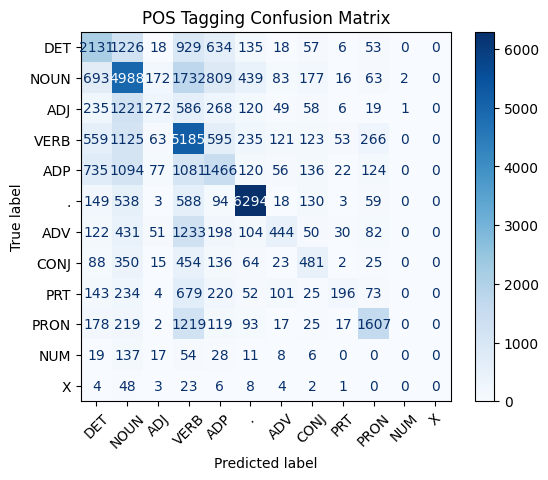


Example 1:
Words:      Well , now she can sleep in the street for all I care '' ! !
True tags:  PRT . ADV PRON VERB VERB ADP DET NOUN ADP PRT PRON VERB . . .
Pred tags:  ADV . PRT VERB ADP DET NOUN ADP PRON VERB VERB PRT VERB . . .

Example 2:
Words:      `` That isn't like you , Janice '' , Chris said uncomfortably .
True tags:  . DET VERB ADP PRON . NOUN . . NOUN VERB ADV .
Pred tags:  . CONJ ADV VERB . . . . . VERB VERB NOUN .

Example 3:
Words:      Then I felt uncomfortable , too .
True tags:  ADV PRON VERB ADJ . ADV .
Pred tags:  ADV PRON VERB VERB . ADV .

Example 4:
Words:      I didn't want to be like that , mean and bitter .
True tags:  PRON VERB VERB PRT VERB ADP DET . ADJ CONJ ADJ .
Pred tags:  PRON VERB VERB PRT VERB ADP NOUN . CONJ ADP NOUN .

Example 5:
Words:      But , darn it all , why should we help a couple of spoiled snobs who had looked down their noses at us ? ?
True tags:  CONJ . VERB PRON PRT . ADV VERB PRON VERB DET NOUN ADP VERB NOUN PRON VERB VERB ADP DET N

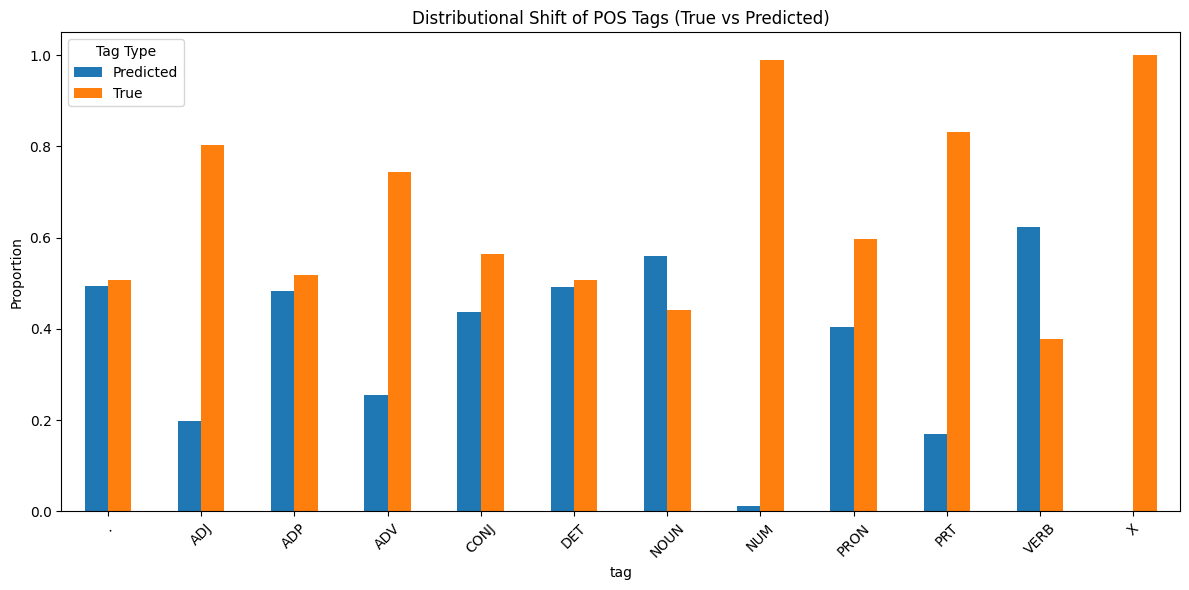

In [8]:
import numpy as np

def evaluate_seq2seq(model, test_X, test_Y, idx2tag, batch_size=32, device="cuda"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for i in tqdm(range(0, len(test_X), batch_size), desc="Evaluating"):
            Xb = test_X[i:i+batch_size].to(device)   # (B, seq)
            Yb = test_Y[i:i+batch_size].to(device)   # (B, seq)

            # Forward pass (no one-hot needed, model has embeddings)
            outputs = model(Xb, targets=None, teacher_forcing_ratio=0.0)   # (B, seq, num_tags)
            preds = outputs.argmax(dim=-1)

            # Flatten batch
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(Yb.view(-1).cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Mask padding index (0)
    mask = all_labels != 0
    all_preds = all_preds[mask]
    all_labels = all_labels[mask]

    # Prepare tag names
    labels = list(range(1, len(idx2tag)))  # skip PAD
    target_names = [idx2tag[i] for i in labels]

    # Metrics
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, labels=labels, target_names=target_names))

    cm = confusion_matrix(all_labels, all_preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
    plt.title("POS Tagging Confusion Matrix")
    plt.show()

# Load JSON splits
with open("train-data.json") as f: train_data = json.load(f)
with open("val-data.json") as f: val_data = json.load(f)
with open("test-data.json") as f: test_data = json.load(f)

def convert_back(data):
        return [[(list(d.keys())[0], list(d.values())[0]) for d in sent] for sent in data]

train_data, val_data, test_data = map(convert_back, [train_data, val_data, test_data])

# Build vocab
word2idx, tag2idx, idx2tag = build_vocab(train_data + val_data + test_data)
vocab_size, num_tags = len(word2idx), len(tag2idx)

max_len = 50
train_X, train_Y = encode(train_data, word2idx, tag2idx, max_len)
val_X, val_Y     = encode(val_data, word2idx, tag2idx, max_len)
test_X, test_Y   = encode(test_data, word2idx, tag2idx, max_len)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Seq2Seq(vocab_size, hidden_size=128, num_tags=num_tags, emb_dim=128, pad_idx=0).to(device)

ckpt_path = "model.pt"
model.load_state_dict(torch.load(ckpt_path, map_location=device))

evaluate_seq2seq(
    model, 
    test_X, 
    test_Y, 
    idx2tag, 
    batch_size=32, 
    device=device
)

def show_predictions(model, test_X, test_Y, idx2tag, idx2word, num_examples=5, device="cuda"):
    model.eval()
    with torch.no_grad():
        for i in range(num_examples):
            x = test_X[i].unsqueeze(0).to(device)   # (1, seq)
            y_true = test_Y[i].cpu().numpy()        # (seq,)

            outputs = model(x, targets=None, teacher_forcing_ratio=0.0)  # (1, seq, num_tags)
            preds = outputs.argmax(dim=-1).squeeze(0).cpu().numpy()     # (seq,)

            # Convert back to words and tags, skipping PAD (0)
            words = [idx2word[idx] for idx in test_X[i].cpu().numpy() if idx != 0]
            true_tags = [idx2tag[idx] for idx in y_true if idx != 0]
            pred_tags = [idx2tag[idx] for idx in preds[:len(words)]]

            print(f"\nExample {i+1}:")
            print("Words:     ", " ".join(words))
            print("True tags: ", " ".join(true_tags))
            print("Pred tags: ", " ".join(pred_tags))

idx2word = {i:w for w,i in word2idx.items()}

show_predictions(model, test_X, test_Y, idx2tag, idx2word, num_examples=5, device=device)

import pandas as pd
import matplotlib.pyplot as plt

def plot_tag_distribution_shift(model, test_X, test_Y, idx2tag, batch_size=32, device="cuda"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for i in range(0, len(test_X), batch_size):
            Xb = test_X[i:i+batch_size].to(device)
            Yb = test_Y[i:i+batch_size].to(device)

            outputs = model(Xb, targets=None, teacher_forcing_ratio=0.0)  # (B, seq, num_tags)
            preds = outputs.argmax(dim=-1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(Yb.cpu().numpy().flatten())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Mask padding index
    mask = all_labels != 0
    all_preds = all_preds[mask]
    all_labels = all_labels[mask]

    # Convert to tag names
    true_tags = [idx2tag[i] for i in all_labels]
    pred_tags = [idx2tag[i] for i in all_preds]

    # Put into pandas DataFrame
    df_true = pd.DataFrame({"tag": true_tags, "type": "True"})
    df_pred = pd.DataFrame({"tag": pred_tags, "type": "Predicted"})
    df = pd.concat([df_true, df_pred])

    # Count frequencies
    counts = df.groupby(["type", "tag"]).size().reset_index(name="count")

    # Pivot to compare True vs Predicted side by side
    pivot = counts.pivot(index="tag", columns="type", values="count").fillna(0)

    # Normalize to proportions
    pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

    # Plot
    pivot_norm.plot(kind="bar", figsize=(12, 6))
    plt.title("Distributional Shift of POS Tags (True vs Predicted)")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.legend(title="Tag Type")
    plt.tight_layout()
    plt.show()

    return pivot, pivot_norm

pivot, pivot_norm = plot_tag_distribution_shift(model, test_X, test_Y, idx2tag, batch_size=32, device=device)